# Interactive Visualizion with Open Altimetry & Google Earth Engine

## Learning Objectives
- Load ICESat-2 data using the OpenAltimetry API. 
- Query Google Earth Engine for geospatial raster data and display it along with ICESat-2 ground tracks on an interactive map.
- Better understand what you are looking at in ATL03 features without downloading a bunch of files.

## Computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

In [2]:
from utils.oa import dataCollector

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Downloading data from the OpenAltimetry API

Let's say we have found some data that looks weird to us, and we don't know what's going on.

![gif showing how to get to the data in OpenAltimetry](https://user-images.githubusercontent.com/23487320/159029794-748ff020-32a7-4794-958d-d27340ffd6ca.gif)

### A short explanation of how I got the data:
I went to [openaltimetry.org](https://openaltimetry.org/) and selected **BROWSE ICESAT-2 DATA**. Then I selected **ATL 06** (Land Ice Height) on the top right, and switched the projection🌎 to **Antarctic**. Then I selected **January 16, 2020** in the calendar📅 on the bottom left, and toggled the **cloud**☁️ button to show MODIS imagery of that date. I then zoomed in on my region of interest (Nivlisen Ice Shelf). Looks like there's a cloud in MODIS, but ICESat-2 has data. I wonder what this cloud is hiding?🤔 

To find out, I clicked on **SELECT A REGION** on the top left, and drew a rectangle around that mysterious cloud. When right-clicking on that rectangle, I could select **View Elevation profile**. This opened a new tab, and showed me ATL06 and ATL08 elevations. 

It looks like ATL06 can't decide where the surface is, and ATL08 tells me that there's a forest canopy on this ice shelf in Antarctica?? To get to the bottom of this, I scrolled all the way down and selected 🛈**Get API URL**. The website confirms that the *"API endpoint was copied to clipboard."* Now I can use this to access the data myself. 

*Note: Instead of trying to find Nivlisen Ice Shelf yourself, you can access the OpenAltimetry page shown above by going to [this annotation🏷️](https://openaltimetry.org/data/icesat2/?annoId=501&shareKey=3407f280d15816afe4bf77cbb719210e). Just left-click on the red box and select "View Elevation Profile".*

### Getting the OpenAltimetry info into python
All we need to do is to paste the API URL that we copied from the webpage into a string. 
We also need to specify which beam we would like to look at. The **GT2R** ground track looks funky, so let's look at that one!

In [4]:
# paste the API URL from OpenAltimetry below, and specify the beam you are interested in
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'

We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. 

In [5]:
is2data = dataCollector(oaurl=oa_api_url,beam=gtx, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&outputFormat=json&beamName=gt2r&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34956862465471, -70.2449105354736]
Longitude limits: [12.107692195781404, 12.426364789894341]


Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [6]:
latlims = [-70.34957, -70.24491]
lonlims = [12.10769, 12.42636]
rgt = 312
gtx = 'gt2r'
date = '2020-01-16'
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34957, -70.24491]
Longitude limits: [12.10769, 12.42636]


Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads ATL03, ATL06 and ATL08 data based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [7]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [8]:
vars(is2data)

{'url': 'https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter',
 'date': '2020-01-16',
 'track': 312,
 'beam': 'gt2r',
 'latlims': [-70.34957, -70.24491],
 'lonlims': [12.10769, 12.42636],
 'atl03':              lat        lon           h   conf
 0     -70.244852  12.299888  248.103740  Noise
 1     -70.244859  12.299886  261.201020  Noise
 2     -70.244865  12.299884  243.059620  Noise
 3     -70.244862  12.299884  118.523254  Noise
 4     -70.244859  12.299884    9.918441  Noise
 ...          ...        ...         ...    ...
 46111 -70.349453  12.260788   44.356140   High
 46112 -70.349459  12.260786   45.128857   High
 46113 -70.349472  12.260782   44.818504   High
 46114 -70.349472  12.260782   45.072422   High
 46115 -70.349478  12.260779   44.981472   High
 
 [46116 rows x 4 columns],
 'atl06':            lat        lon          h
 0   -70.245025  12.2

## Plotting the ATL03, ATL06 and ATL08 data

Now let's plot this data. Here, we are just creating an empty figure `fig` with axes `ax`.

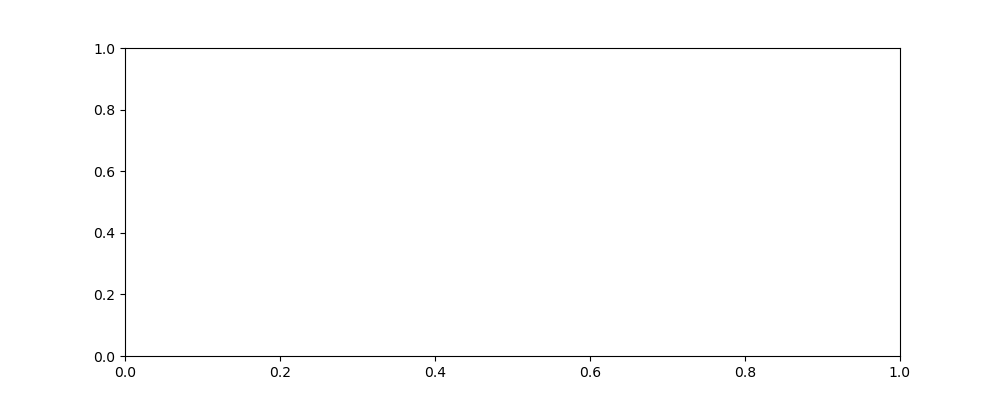

In [9]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[10,4])

Let's plot ATL06 elevation versus latitude on these axes above.

In [10]:
atl06, = ax.plot(is2data.atl06.lat, is2data.atl06.h, label='ATL06')

Similarly, we can add ATL08 to the plot. Let's make this one dashed by adding `linestyle='--'`.

In [11]:
atl08, = ax.plot(is2data.atl08.lat, is2data.atl08.h, label='ATL08', linestyle='--')

For ATL03, we want a scatter plot.

In [12]:
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, color='black', label='ATL03')

Now this doesn't look so great. We're not interested in all these noise photons, so we need to adjust the extent of the axes. 
We can do this interactively on the plot. 

Alternatively, we could adjust the axes to whichever values we like by calling something like the following:

In [13]:
ax.set_xlim((-70.34, -70.25))
ax.set_ylim((23, 47))

(23.0, 47.0)

Have you ever lost points on a problem set because you didn't label your axes? Let's label them axes!  
...and let's throw in a fun title for good measure too. 

In [14]:
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title('Some ICESat-2 data I found on OpenAltimetry!')

Text(0.5, 1.0, 'Some ICESat-2 data I found on OpenAltimetry!')

To know what we're looking at, we need a legend as well. 

In [15]:
ax.legend(loc='lower right')

...and we can do all sorts of other funky stuff. Here it's nice to have some context about the data. (Because we don't want to find this plot somewhere in a year from now just to realize we have no idea where the data came from...)

In [16]:
# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam, 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, 0.03, info,
                   horizontalalignment='left', 
                   verticalalignment='bottom', 
                   transform=ax.transAxes,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

In [17]:
fig.tight_layout()

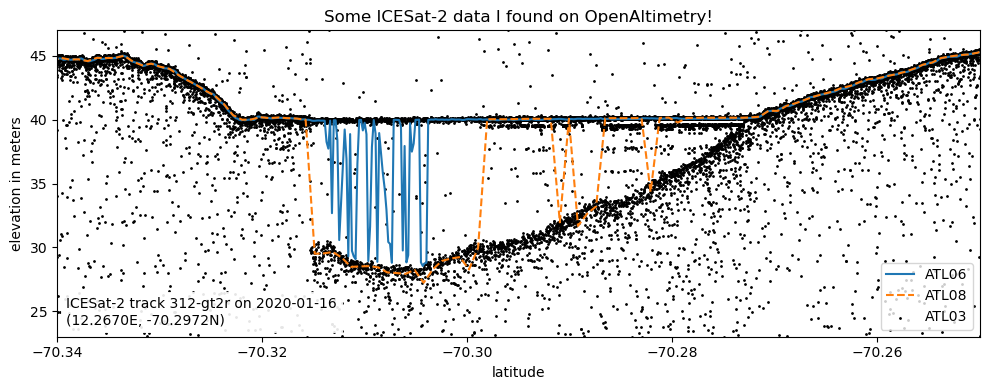

In [18]:
fig

## Saving the Plot to a file

In [19]:
fig.savefig('my-plot.jpg')

This is not really publication quality, so we can adjust the resolution using the `dpi` argument.

In [20]:
fig.savefig('my-plot-better-resolution.jpg',dpi=300)

To make plots easier to produce, the `dataCollector` class also has a method to plot the data that we downloaded. 

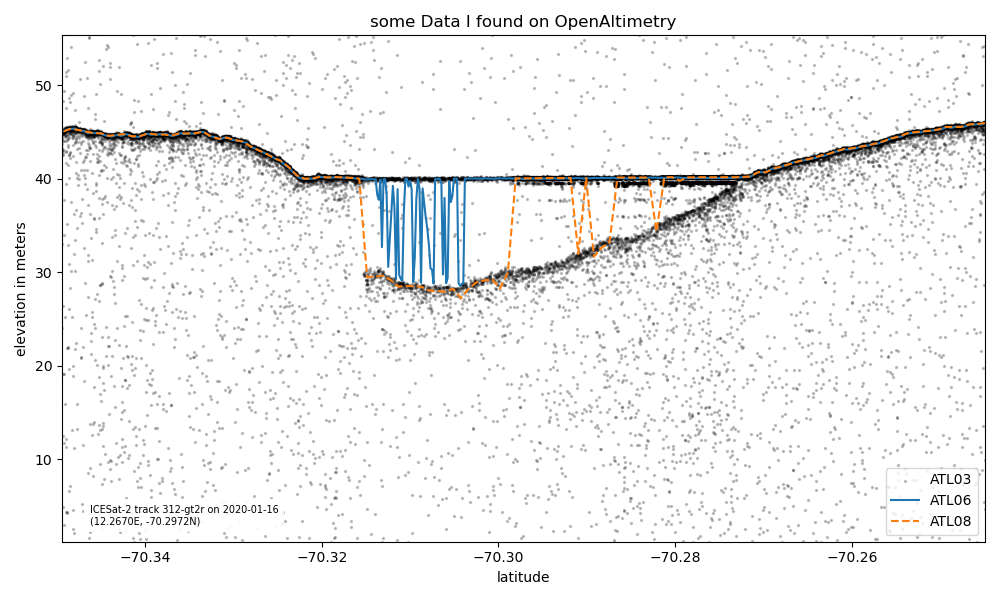

In [21]:
fig = is2data.plotData()

Let's wrap this all into a function!

In [22]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

## Exercise 1 
**Find some data from openaltimetry that you would like to read into python, and plot it here.**

Look for small-scale features, where ATL03 photon cloud may give us some information that we would not get from ATL08 or ATL06 (Say a few hundred meters to 20 kilometers along-track. *Hint: OpenAltimetry has a scale bar.*)

If you don't know where to start with OpenAltimetry, you can look at any of these annotations below:
- Like mountains? Look at gt2l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Like the ocean? Look at gt1r [here](http://openaltimetry.org/data/icesat2/?annoId=505&shareKey=4345379a3318b8c055d026723ca60162).
- Like the previous example but don't wanna go to Antarctica? Look at gt3l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Curious about more ice shelf suff? Look at gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=207&shareKey=e90e9fb891a716064f5cc8b0e13f750a).
- Can you tell what's going on in gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=504&shareKey=aae14eeca098358c6f9e686ca659a93e)? 

In [23]:
##### YOUR CODE GOES HERE
# url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2021-11-21&minx=-148.9599056845995&miny=60.363639559447975&maxx=-148.85273497592718&maxy=60.44972969308079&trackId=914&beamName=gt1r&beamName=gt1l&outputFormat=json'
# gtx = 'gt1r'
# myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='AK_20211121')
# myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)
# myplot

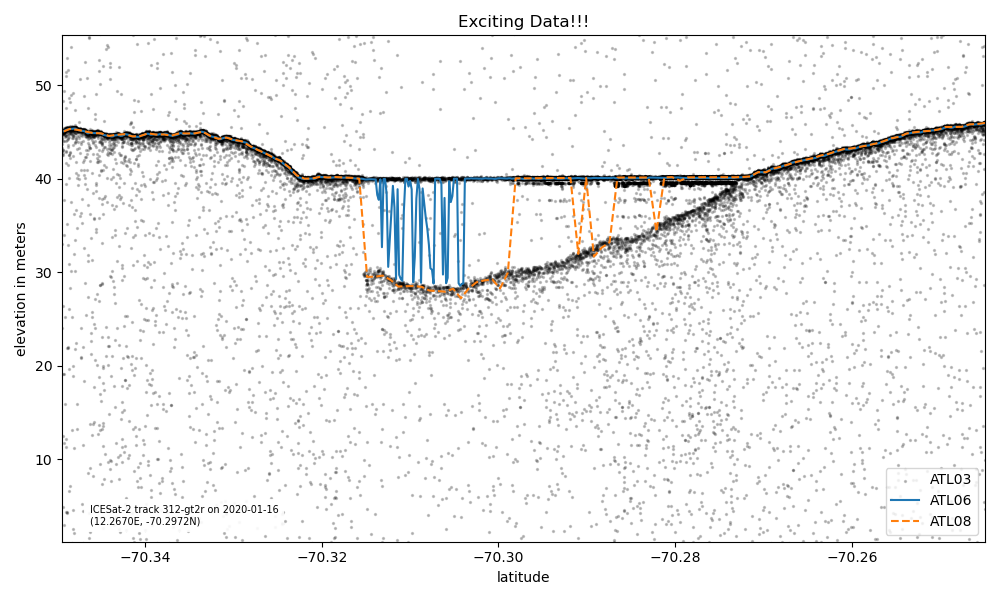

In [26]:
url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Exciting Data!!!')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

## Ground Track Stats
So far we have only seen the data in elevation vs. latitude space. It's probably good to know what the scale on the x-axis is here in units that we're familiar with. 

In [27]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = mydata.atl08.lat[0], mydata.atl08.lat.iloc[-1]
lon1, lon2 = mydata.atl08.lon[0], mydata.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 11.7 kilometers long.


## Google Earth Engine

Google Earth Engine (GEE) has a large [catalog](https://developers.google.com/earth-engine/datasets) of geospatial raster data, which is ready for analysis in the cloud. It also comes with an online JavaScript code editor.  
<img src="misc/gee_codeeditor.png" alt="gif showing how to get to the data in OpenAltimetry" width="600px">  
But since we all seem to be using python, it would be nice to have these capabilities available in our Jupyter comfort zone...

Thankfully, there is a [python API for GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), which we have imported using `import ee` earlier. It doesn't come with an interactive map, but the python package [geemap](https://geemap.org/) has us covered!

## Show a ground track on a map
We can start working on our map by calling `geemap.Map()`. This just gives us a world map with a standard basemap. 

In [28]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Now we need to add our ICESat-2 gound track to that map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [29]:
ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
gtx_feature

Now that we have it in the right format, we can add it as a **layer** to the map.

In [30]:
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')

According to the cell above this should be a red line. But we still can't see it, because we first need to tell the map where to look for it.  
Let's calculate the center longitude and latitude, and center the map on it. 

In [31]:
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=2);

So we actually couldn't see it because it was in Antarctica (of all places!).  
Unfortunately the basemap here doesn't give us much more information. Let's add a satellite imagery basemap.
This is a good time to look at the layer control on the top right.

In [32]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.layer_opacity(name='Google Satellite', value=0.5)
Map.setCenter(center_lon, center_lat, zoom=9);

Okay, we're on an ice shelf!
But the basemap was plotted over the ground track, so let's add that back again on top of it.

In [33]:
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

...looks like this basemap still doesn't give us any more clues about the nature of this weird ICESat-2 data. Let's dig deeper.

## Query for Sentinel-2 and Landsat 8 images
Both of these satellites take images of most places on our planet every week or so. Maybe these images can tell us what was happening here around the same time that ICESat-2 acquired our data?

The imagery scenes of both satellites (amongst many more) live in image collections on Google Earth Engine.  
You can find all collections here: https://developers.google.com/earth-engine/datasets/catalog/

Let's have a look at Landsat 8 first. The above link tells us we can find some images under `'LANDSAT/LC08/C01/T2'`.

In [34]:
collection_name1 = 'LANDSAT/LC08/C01/T2'  # Landsat 8 earth engine collection 
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2

### Access an image collection
To access the collection, we call `ee.ImageCollection`:

In [35]:
collection = ee.ImageCollection(collection_name1)
collection

Can we find out how many images there are in total?

In [36]:
number_of_scenes = collection.size()
number_of_scenes

Actually, asking for the size of the collection does not do anything on the client side (our local machine). It just tells Earth Engine on the server-side that this variable refers to the size of the collection, which we may need later to do some analysis on the server.

To get this information to our own machine, we need to call `.getInfo()`. *(This takes a while...)*

In [37]:
number_of_scenes = collection.size().getInfo()
number_of_scenes

897557

### Filter an image collection
Who wants to look at almost a million pictures? I don't. So let's try to narrow it down.  
Let's start with only images that overlap with the center of our ground track. 

In [38]:
# the point of interest (center of the track) as an Earth Engine Geometry
point_of_interest = ee.Geometry.Point(center_lon, center_lat)

In [39]:
collection = collection.filterBounds(point_of_interest)

In [40]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 527 images in the spatially filtered collection.


Much better! Now let's only look at images that were taken soon before or after ICESat-2 passed over this spot.

In [41]:
days_buffer_imagery = 15

In [42]:
dateformat = '%Y-%m-%d'
datetime_requested = datetime.strptime(mydata.date, dateformat)
search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

Search for imagery from 2020-01-01 to 2020-01-31.


In [43]:
collection = collection.filterDate(search_start, search_end)

In [44]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 10 images in the spatially filtered collection.


We can also sort the collection by date (`'system:time_start'`), to make things a little less messy moving forward.

In [45]:
collection = collection.sort('system:time_start') 

### Get image collection info
Again, we need to use `.getInfo()` to actually see any information on our end. 

In [46]:
info = collection.getInfo()

This is a python dictionary. 

In [47]:
type(info)

dict

Let's see what's inside!

In [48]:
info.keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties', 'features'])

`'features'` sounds like it could hold information about the images we are trying to find...

In [49]:
type(info['features'])

list

In [50]:
len(info['features'])

10

A list of 10 things! Those are probably the 10 images in the collection. Let's pick the first one and dig deeper!

In [51]:
feature_number = 0
info['features'][0].keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties'])

In [52]:
info['features'][feature_number]['id']

'LANDSAT/LC08/C01/T2/LC08_166109_20200105'

Looks like we found a reference to a Landsat image! Let's look at the `'bands'`.

In [53]:
for band in info['features'][feature_number]['bands']:
    print(band['id'], end=', ')

B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, BQA, 

`'properties'` could be useful too! 

In [54]:
info['features'][0]['properties'].keys()

dict_keys(['RADIANCE_MULT_BAND_5', 'RADIANCE_MULT_BAND_6', 'RADIANCE_MULT_BAND_3', 'RADIANCE_MULT_BAND_4', 'RADIANCE_MULT_BAND_1', 'RADIANCE_MULT_BAND_2', 'K2_CONSTANT_BAND_11', 'K2_CONSTANT_BAND_10', 'system:footprint', 'REFLECTIVE_SAMPLES', 'SUN_AZIMUTH', 'CPF_NAME', 'DATE_ACQUIRED', 'ELLIPSOID', 'STATION_ID', 'FALSE_NORTHING', 'RESAMPLING_OPTION', 'ORIENTATION', 'WRS_ROW', 'RADIANCE_MULT_BAND_9', 'TARGET_WRS_ROW', 'RADIANCE_MULT_BAND_7', 'RADIANCE_MULT_BAND_8', 'FALSE_EASTING', 'IMAGE_QUALITY_TIRS', 'TRUNCATION_OLI', 'CLOUD_COVER', 'COLLECTION_CATEGORY', 'GRID_CELL_SIZE_REFLECTIVE', 'CLOUD_COVER_LAND', 'COLLECTION_NUMBER', 'IMAGE_QUALITY_OLI', 'LANDSAT_SCENE_ID', 'WRS_PATH', 'PANCHROMATIC_SAMPLES', 'PANCHROMATIC_LINES', 'REFLECTIVE_LINES', 'TIRS_STRAY_LIGHT_CORRECTION_SOURCE', 'system:asset_size', 'system:index', 'REFLECTANCE_ADD_BAND_1', 'REFLECTANCE_ADD_BAND_2', 'DATUM', 'REFLECTANCE_ADD_BAND_3', 'REFLECTANCE_ADD_BAND_4', 'RLUT_FILE_NAME', 'REFLECTANCE_ADD_BAND_5', 'REFLECTANCE_AD

That's a lot going on right there! But `'LANDSAT_PRODUCT_ID'` is probably useful. Let's go through all our features and print the product id.

In [55]:
for feature in info['features']:
    print(feature['properties']['LANDSAT_PRODUCT_ID'])

LC08_L1GT_166109_20200105_20200113_01_T2
LC08_L1GT_166110_20200105_20200113_01_T2
LC08_L1GT_164110_20200107_20200114_01_T2
LC08_L1GT_167109_20200112_20200127_01_T2
LC08_L1GT_165110_20200114_20200127_01_T2
LC08_L1GT_166109_20200121_20200128_01_T2
LC08_L1GT_166110_20200121_20200128_01_T2
LC08_L1GT_164110_20200123_20200128_01_T2
LC08_L1GT_167109_20200128_20200210_01_T2
LC08_L1GT_165110_20200130_20200211_01_T2


### Access images by ID 
Turns out we can access images from the `'image collection'` by their `'id'`.  

In [56]:
this_id = info['features'][feature_number]['id']
print(this_id)
myImage = ee.Image(this_id)
myImage

LANDSAT/LC08/C01/T2/LC08_166109_20200105


### Add a Landsat image to the map
The visible bands in Landsat 8 are `'B2'`:blue, `'B3'`:green, `'B4'`:red.  
So to show a "true color" RGB composite image on the map, we need to select these bands in the R-G-B order: 

In [57]:
myImage_RGB = myImage.select('B4', 'B3', 'B2')
Map.addLayer(myImage_RGB, name='my image')

This seems to have worked. But there's clouds everywhere. We can try another random image: 

In [58]:
feature_number = 5
myImage = ee.Image(info['features'][feature_number]['id'])
myImage_RGB = myImage.select('B4', 'B3', 'B2')
Map.addLayer(myImage_RGB, name='my other image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

**More clouds...** 

### Add multiple images as layers
We need a better approach to get anywhere here.  
Let's start over with a new map, and add all the images we have as different layers. 

In [59]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')

for i, feature in enumerate(info['features']):
    image_id = feature['id']
    reference = '%02d: %s' % (i, image_id)
    print(reference)
    myImage_RGB = ee.Image(image_id).select('B4', 'B3', 'B2')
    Map.addLayer(myImage_RGB, name=reference, shown=False)

Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map.centerObject(gtx_feature, zoom=10)
Map

00: LANDSAT/LC08/C01/T2/LC08_166109_20200105
01: LANDSAT/LC08/C01/T2/LC08_166110_20200105
02: LANDSAT/LC08/C01/T2/LC08_164110_20200107
03: LANDSAT/LC08/C01/T2/LC08_167109_20200112
04: LANDSAT/LC08/C01/T2/LC08_165110_20200114
05: LANDSAT/LC08/C01/T2/LC08_166109_20200121
06: LANDSAT/LC08/C01/T2/LC08_166110_20200121
07: LANDSAT/LC08/C01/T2/LC08_164110_20200123
08: LANDSAT/LC08/C01/T2/LC08_167109_20200128
09: LANDSAT/LC08/C01/T2/LC08_165110_20200130


Map(center=[-70.29716966295749, 12.280379542094062], controls=(WidgetControl(options=['position', 'transparent…

\**The fifth image looks good!** Let's go ahead and download that one.  
From the print statements above we see that it's id is `LANDSAT/LC08/C01/T2/LC08_165110_20200114`

### Download images from Earth Engine

We can use [`.getDownloadUrl()`](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl) on an Earth Engine image.  

It needs a CRS (here we use [`'EPSG:3031'` (WGS 84 / Antarctic Polar Stereographic)](https://epsg.io/3031) because we know we are in Antarctica. It also asks for a scale, which is just the pixel size in meters (30 m for Landsat 8 visible bands). It also asks for the region we would like to export; here we use a [`.buffer`](https://developers.google.com/earth-engine/apidocs/ee-geometry-buffer) around the center.

*(Note: This function can only be effectively used for small download jobs because there is a request size limit. Here, we only download a small region around the ground track, and convert the image to an 8-bit RGB composite to keep file size low. For larger jobs you should use [`Export.image.toDrive`](https://developers.google.com/earth-engine/apidocs/export-image-todrive))*

In [60]:
selected_image_id = 'LANDSAT/LC08/C01/T2/LC08_165110_20200114'
rgb = ee.Image(selected_image_id).select('B4', 'B3', 'B2')

buffer_around_center_meters = ground_track_length*0.7
download_region = point_of_interest.buffer(buffer_around_center_meters)
rgbmax = rgb.reduce(ee.Reducer.max()).reduceRegion(reducer=ee.Reducer.max(), geometry=download_region, bestEffort=True, maxPixels=1e6)
rgbmin = rgb.reduce(ee.Reducer.min()).reduceRegion(reducer=ee.Reducer.min(), geometry=download_region, bestEffort=True, maxPixels=1e6)
rgb = rgb.unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0).multiply(255).uint8()

rgb_info = rgb.getInfo()
downloadURL = rgb.getDownloadUrl({'name': 'mySatelliteImage',
                                  'crs': 'EPSG:3031',
                                  'scale': rgb_info['bands'][0]['crs_transform'][0],
                                  'region': download_region,
                                  'filePerBand': False,
                                  'format': 'GEO_TIFF'})

downloadURL

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09e7e7f4897a6e7f73e209cdc4dcd71c-c46f140efe98c105de89894ed878b3c2:getPixels'

We can save the content of the download URL with the [`requests`](https://docs.python-requests.org/en/latest/) library. 

In [61]:
response = requests.get(downloadURL)
filename = 'my-satellite-image.tif'
with open(filename, 'wb') as f:
    f.write(response.content)

### Open a GeoTIFF in rasterio
Now that we have saved the file, we can open it locally with the [`rasterio`](https://rasterio.readthedocs.io/en/latest/intro.html) library.

In [62]:
myImage = rio.open(filename)
myImage

<open DatasetReader name='my-satellite-image.tif' mode='r'>

### Plot a GeoTIFF in Matplotlib
Now we can easily plot the image in a matplotlib figure, just using the [`rasterio.plot()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html) module. 

<AxesSubplot:>

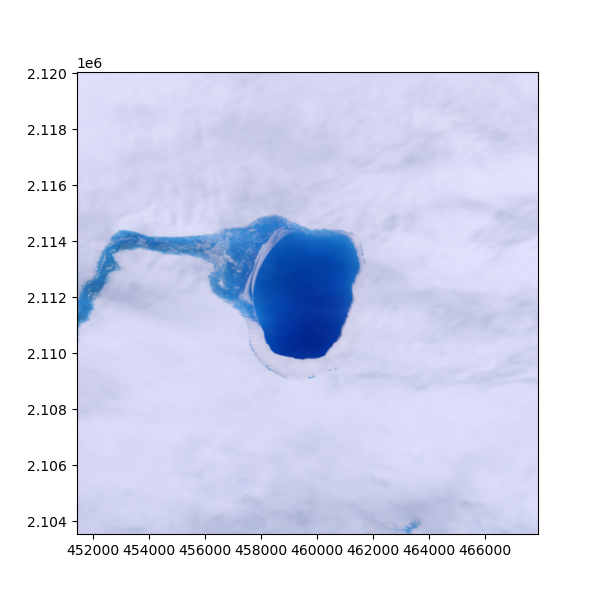

In [63]:
fig, ax = plt.subplots(figsize=[6,6])
plot.show(myImage, ax=ax)

### transform the ground track into the image CRS
Because our plot is now in the Antarctic Polar Stereographic Coordrinate Reference System, we need to project the coordinates of the ground track from lon/lat values. The [`rasterio.warp.transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html) function has us covered. From then on, it's just plotting in Matplotlib. 

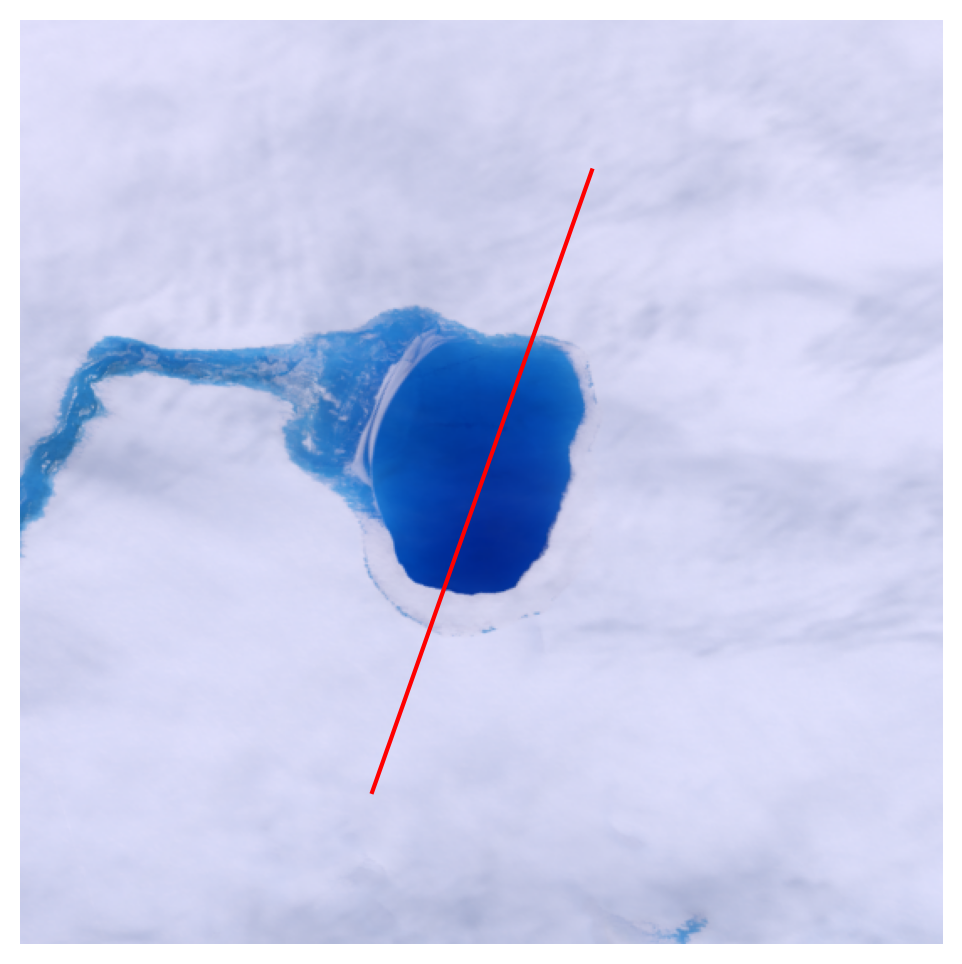

In [64]:
gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=mydata.atl08.lon, ys=mydata.atl08.lat)
ax.plot(gtx_x, gtx_y, color='red', linestyle='-')
ax.axis('off')
fig

## Putting it all together
The code above is found more concisely in two more methods: 
- `dataCollector.makeGEEmap(days_buffer=25)`
- `dataCollector.plotDataAndMap(scene_id, crs='EPSG:3857', title='ICESat-2 Data')`
We can now do everything we did in this tutorial in a few lines!

In [65]:
mydata.makeGEEmap()

The ground track is 11707 meters long.
Search for imagery from 2019-12-22 to 2020-02-10.
--> Number of scenes found within +/- 25 days of ICESat-2 overpass: 26
----> This is too many. Narrowing it down...
Search for imagery from 2020-01-02 to 2020-01-30.
--> Number of scenes found within +/- 14 days of ICESat-2 overpass: 15
00: 2020-01-05 ( 11 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_166109_20200105
01: 2020-01-05 ( 11 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_166110_20200105
02: 2020-01-06 ( 10 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200106T080919_20200106T080922_T32DPH
03: 2020-01-06 ( 10 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200106T080919_20200106T080922_T32DPG
04: 2020-01-07 (  9 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_164110_20200107
05: 2020-01-12 (  4 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_167109_20200112
06: 2020-01-14 (  2 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_165110_20

Map(center=[-70.29716272683743, 12.280333059231324], controls=(WidgetControl(options=['position', 'transparent…

Downloaded downloads/LANDSAT-LC08-C01-T2-LC08_165110_20200114-8bitRGB.tif
Saved plot to: plots/LANDSAT-LC08-C01-T2-LC08_165110_20200114-8bitRGB-plot.jpg


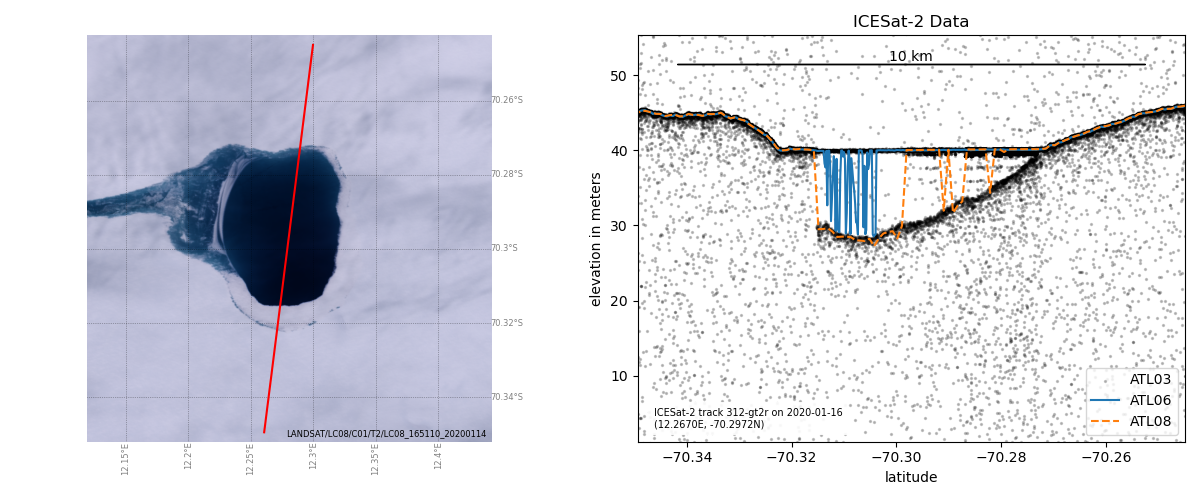

In [66]:
myProductId = 'LANDSAT/LC08/C01/T2/LC08_165110_20200114' # <-- copy-pasted from above, after looking at the layers in the map
figure = mydata.plotDataAndMap(myProductId)

## Exercise 2
**Plot your data from before with a suitable satellite image.**

Use the OpenAltimetry API URL that you already pasted in Exercise 1 for this. Edit the code below and paste it here again.

In [67]:
##### YOUR CODE GOES HERE
# url = 'http://???.org/??'
# gtx = 'gt??'
# yourData = dataCollector(oaurl=url, beam=gtx)
# yourData.makeGEEmap()

In [68]:
##### MORE OF YOUR CODE GOES HERE
# scene_id='<paste the scene id corresponding to whichever image from the GEE map you would like to use>'
# fig = yourData.plotDataAndMap(scene_id, title='<your figure title goes here>')
# fig.savefig('geemap_tutorial_exercise2.jpg', dpi=300) 

## Summary

 🎉 Congratulations! You've completed this tutorial and have seen how we can put ICESat-2 photon-level data into context using Google Earth Engine and the OpenAltimetry API. 
 
You can explore a few more use cases for this code (and possible solutions for Exercise 2) in [this notebook](Visualization_geemap_use_examples.ipynb).

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)